In [1]:
import os
from pathlib import Path
import DifferentiableStateSpaceModels
from DifferentiableStateSpaceModels import *
from sympy import *
from copy import deepcopy

init_printing()  # for nice sympy expressions in jupyter

In [2]:
# Define the symbols
α, β, ρ, δ, σ, Ω_1 = symbols('α β ρ δ σ Ω_1')  # parameters
t = symbols('t', integer=True)  # time index (integer)
k, z, c, q = symbols('k z c q', cls=Function)  # undefined functions

# Define the states, controls, and parameters
x = [k, z]  # states - list of functions
y = [c, q]  # controls - list of functions
p = [α, β, ρ, δ, σ, Ω_1]  # parameters - list of symbols

# Define the system of model equations - list of expressions
H = [
    1 / c(t) - (β / c(t + 1)) * (α * exp(z(t + 1)) * k(t + 1)**(α - 1) + (1 - δ)),
    c(t) + k(t + 1) - (1 - δ) * k(t) - q(t),
    q(t) - exp(z(t)) * k(t)**α,
    z(t + 1) - ρ * z(t)
]

# Define the steady states - list of equations
steady_states = [
    Eq(k(oo), (((1 / β) - 1 + δ) / α)**(1 / (α - 1))),
    Eq(z(oo), 0),
    Eq(c(oo), (((1 / β) - 1 + δ) / α)**(α / (α - 1)) - δ * (((1 / β) - 1 + δ) / α)**(1 / (α - 1))),
    Eq(q(oo), (((1 / β) - 1 + δ) / α)**(α / (α - 1)))
]

# Define the matrix for the 1 shock
Γ = Matrix([σ])  # DenseMatrix

# Define the n_x * n_ϵ matrix
η = Matrix([0, -1])  # DenseMatrix

# Define the observation matrix
Q = Matrix([[1.0, 0, 0, 0], [0, 0, 1.0, 0]])  # DenseMatrix

# Define the diagonal cholesky of covariance matrix for observation noise
Ω = [Ω_1, Ω_1]  # list of symbols

# Generates the files and includes if required.  If the model is already created, then just loads
overwrite_model_cache = True

In [3]:
def default_model_cache_location():
    """
    Returns the default location for the model cache
    :return: path of a folder joining the package directory and ".function_cache"
    """
    return os.path.join(Path(DifferentiableStateSpaceModels.__file__).parent.absolute(), ".function_cache")


max_order = 2
steady_states_iv = None
model_name = "rbc"
model_cache_location = default_model_cache_location()
print_level = 1
skipzeros = True
fillzeros = False
simplify_Ψ = True
do_simplify = True
simplify_p = True

In [4]:
# Check inputs
assert max_order in [1, 2], "max_order must be 1 or 2"

# path to save the model modules
module_cache_path = os.path.join(
    model_cache_location, model_name, "__init__.py")

# only load cache if the module isn't already loaded in memory
if (str(model_name) in globals()) and (not overwrite_model_cache):
    if print_level > 0:
        print(f"Using existing module {model_name}\n")

# if path already exists
if (os.path.exists(module_cache_path)) and (not overwrite_model_cache):
    # path exists and not overwriting
    if print_level > 0:
        print(f"Model already generated at {module_cache_path}\n")

In [5]:
    # model structure
    n_y = len(y)  # number of control variables
    n_x = len(x)  # number of state variables
    n = n_y + n_x  # number of all variables
    n_p = len(p)  # number of parameters
    assert n_p > 0, "At least one parameter must be defined"
    n_ϵ = η.shape[1]  # number of shocks
    n_z = n if Q is None else Q.shape[0]  # number of observables

In [6]:
    # Get the markovian variables and create substitutions
    y_subs = [make_substitutions(t, y_i) for y_i in y]
    x_subs = [make_substitutions(t, x_i) for x_i in x]
    y = Matrix([y_i['var'] for y_i in y_subs])
    x = Matrix([x_i['var'] for x_i in x_subs])
    y_p = Matrix([y_i['var_p'] for y_i in y_subs])
    x_p = Matrix([x_i['var_p'] for x_i in x_subs])
    y_ss = Matrix([y_i['var_ss'] for y_i in y_subs])
    x_ss = Matrix([x_i['var_ss'] for x_i in x_subs])
    subs = x_subs + y_subs
    all_to_markov = ([sub['markov_t'] for sub in subs] +
                     [sub['markov_tp1'] for sub in subs] + [sub['markov_inf'] for sub in subs])
    all_to_var = [sub['tp1_to_var'] for sub in subs] + [sub['inf_to_var'] for sub in subs]

In [7]:
def equations_to_dict(equations):
    return {str(eq.lhs.subs(all_to_markov).subs(all_to_var)): eq.rhs.subs(all_to_markov) for eq in equations}

In [8]:
    # Begin building the model
    if print_level > 0:
        print("\033[96mBuilding model up to order {}\033[0m".format(max_order))
    if print_level > 1:
        print("\033[96mdo_simplify = {}, simplify_p = {}, simplify Ψ = {}\033[0m".format(
            do_simplify, simplify_p, simplify_Ψ))

Building model up to order 2


In [9]:
    # steady state variables
    y_bar = None if steady_states is None else Matrix(order_vector_by_symbols(
        equations_to_dict(steady_states), [y_sub['symbol'] for y_sub in y_subs]))
    x_bar = None if steady_states is None else Matrix(order_vector_by_symbols(
        equations_to_dict(steady_states), [x_sub['symbol'] for x_sub in x_subs]))
    y_bar_iv = None if steady_states_iv is None else Matrix(order_vector_by_symbols(
        equations_to_dict(steady_states_iv), [y_sub['symbol'] for y_sub in y_subs]))
    x_bar_iv = None if steady_states_iv is None else Matrix(order_vector_by_symbols(
        equations_to_dict(steady_states_iv), [x_sub['symbol'] for x_sub in x_subs]))

In [10]:
    # Get any latex generated stuff we wish for pretty display of the model
    H_latex = latex(H)
    steady_states_latex = latex(steady_states)
    steady_states_iv_latex = latex(steady_states_iv) if steady_states_iv is not None else None

In [11]:
    # steady state requires differentiation after substitution, and wrt [y; x]
    H = [expr.subs(all_to_markov) for expr in H]
    H_bar = deepcopy(H)
    H_bar = substitute_and_simplify(H_bar, all_to_var)

In [12]:
    # Differentiate the system of equations with respect to state/control variables
    if print_level > 2:
        print("\033[96mDifferentiating H\033[0m")
    H_bar_w = nested_differentiate(H_bar, y.col_join(x))
    H_yp = nested_differentiate(H, y_p)
    H_y = nested_differentiate(H, y)
    H_xp = nested_differentiate(H, x_p)
    H_x = nested_differentiate(H, x)

In [13]:
    # Calculate the Hessian for each function in H
    if print_level > 1:
        print("\033[96mCalculating hessian\033[0m")
    Ψ = [hessian(f, y_p.col_join(y).col_join(x_p).col_join(x)) for f in H]
    if simplify_Ψ:
        Ψ = [simplify(expr) for expr in Ψ]

In [14]:
    # Differentiate the Hessian with respect to state/control variables
    if print_level > 2 and max_order >= 2:
        print("\033[96mDifferentiating hessian\033[0m")
    Ψ_yp = None if max_order < 2 else nested_differentiate(Ψ, y_p)
    Ψ_y = None if max_order < 2 else nested_differentiate(Ψ, y)
    Ψ_xp = None if max_order < 2 else nested_differentiate(Ψ, x_p)
    Ψ_x = None if max_order < 2 else nested_differentiate(Ψ, x)

In [15]:
if print_level > 2:
    print("\033[96mDifferentiating steady state with respect to parameters\n\033[0m")
p = Matrix(p)  # DenseMatrix
H_p = differentiate_to_dict(H, p)
Γ_p = differentiate_to_dict(Γ, p)
Ω_p = differentiate_to_dict(Ω, p)
y_bar_p = differentiate_to_dict(y_bar, p)
x_bar_p = differentiate_to_dict(x_bar, p)

In [16]:
H_p['α']

⎡   ⎛  α - 1    zₚ             α - 1  zₚ⎞ ⎤
⎢-β⋅⎝kₚ     ⋅α⋅ℯ  ⋅log(kₚ) + kₚ     ⋅ℯ  ⎠ ⎥
⎢─────────────────────────────────────────⎥
⎢                    cₚ                   ⎥
⎢                                         ⎥
⎢                    0                    ⎥
⎢                                         ⎥
⎢                α  z                     ⎥
⎢              -k ⋅ℯ ⋅log(k)              ⎥
⎢                                         ⎥
⎣                    0                    ⎦

In [17]:
if print_level > 2:
    print(
        "\033[96mDifferentiating H derivatives state with respect to parameters\n\033[0m")

H_yp_p = differentiate_to_dict(H_yp, p)
H_xp_p = differentiate_to_dict(H_xp, p)
H_y_p = differentiate_to_dict(H_y, p)
H_x_p = differentiate_to_dict(H_x, p)

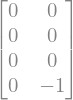

In [18]:
H_x_p['ρ']

In [19]:
if print_level > 2 and max_order >= 2:
    print("\033[96mDifferentiating hessian with respect to parameters\n\033[0m")
Ψ_p = None if max_order < 2 else differentiate_to_dict(Ψ, p)

In [20]:
if print_level > 0:
    print("\033[96mSubstituting and simplifying\n\033[0m")

H = substitute_and_simplify(H, all_to_markov, do_simplify)
H_yp = substitute_and_simplify(H_yp, all_to_var, do_simplify)
H_xp = substitute_and_simplify(H_xp, all_to_var, do_simplify)
H_x = substitute_and_simplify(H_x, all_to_var, do_simplify)
H_y = substitute_and_simplify(H_y, all_to_var, do_simplify)
Ψ = substitute_and_simplify(Ψ, all_to_var, do_simplify)

Substituting and simplifying



In [21]:
Ψ

⎡⎡    ⎛   α - 1    z        ⎞                  α - 2              z           
⎢⎢2⋅β⋅⎝- k     ⋅α⋅ℯ  + δ - 1⎠                 k     ⋅α⋅β⋅(α - 1)⋅ℯ            
⎢⎢───────────────────────────  0  0   0       ─────────────────────           
⎢⎢              3                                        2                    
⎢⎢             c                                        c                     
⎢⎢                                                                            
⎢⎢             0               0  0   0                 0                     
⎢⎢                                                                            
⎢⎢                                2                                           
⎢⎢             0               0  ──  0                 0                     
⎢⎢                                 3                                          
⎢⎢                                c                                           
⎢⎢                                                  

In [22]:
if print_level > 2:
    print("\033[96mSubstituting and simplifying parameter derivatives\n\033[0m")

H_p = substitute_and_simplify(H_p, all_to_var, simplify_p)
Γ_p = substitute_and_simplify(Γ_p, all_to_var, simplify_p)
Ω_p = substitute_and_simplify(Ω_p, all_to_var, simplify_p)
y_bar_p = substitute_and_simplify(y_bar_p, all_to_var, simplify_p)
x_bar_p = substitute_and_simplify(x_bar_p, all_to_var, simplify_p)
H_yp_p = substitute_and_simplify(H_yp_p, all_to_var, simplify_p)
H_xp_p = substitute_and_simplify(H_xp_p, all_to_var, simplify_p)
H_y_p = substitute_and_simplify(H_y_p, all_to_var, simplify_p)
H_x_p = substitute_and_simplify(H_x_p, all_to_var, simplify_p)

In [23]:
H_p['α']

⎡  α - 1                   z ⎤
⎢-k     ⋅β⋅(α⋅log(k) + 1)⋅ℯ  ⎥
⎢────────────────────────────⎥
⎢             c              ⎥
⎢                            ⎥
⎢             0              ⎥
⎢                            ⎥
⎢         α  z               ⎥
⎢       -k ⋅ℯ ⋅log(k)        ⎥
⎢                            ⎥
⎣             0              ⎦

In [24]:
    # Substitute and simplify second order derivatives
    if print_level > 1 and max_order >= 2:
        print("\033[96mSubstituting and simplifying 2nd order\033[0m")
    Ψ_yp = substitute_and_simplify(Ψ_yp, all_to_var, do_simplify)
    Ψ_y = substitute_and_simplify(Ψ_y, all_to_var, do_simplify)
    Ψ_xp = substitute_and_simplify(Ψ_xp, all_to_var, do_simplify)
    Ψ_x = substitute_and_simplify(Ψ_x, all_to_var, do_simplify)

In [25]:
Ψ_x[1][2]

⎡0  0  0  0  0  0           0                0      ⎤
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢0  0  0  0  0  0           0                0      ⎥
⎢                                                   ⎥
⎢                   α - 2            z    α - 1    z⎥
⎢0  0  0  0  0  0  k     ⋅α⋅(1 - α)⋅ℯ   -k     ⋅α⋅ℯ ⎥
⎢                                                   ⎥
⎢                       α - 1    z           α  z   ⎥
⎣0  0  0  0  0  0     -k     ⋅α⋅ℯ          -k ⋅ℯ    ⎦

In [26]:
    if print_level > 2 and max_order >= 2:
        print("\033[96mSubstituting and simplifying 2nd order parameter derivatives\n\033[0m")
    Ψ_p = substitute_and_simplify(Ψ_p, all_to_var, simplify_p)

In [27]:
Ψ_p['α'][0]

⎡         α - 1                   z                                      α - 2
⎢     -2⋅k     ⋅β⋅(α⋅log(k) + 1)⋅ℯ                                      k     
⎢     ──────────────────────────────       0  0  0                      ──────
⎢                    3                                                        
⎢                   c                                                         
⎢                                                                             
⎢                   0                      0  0  0                            
⎢                                                                             
⎢                   0                      0  0  0                            
⎢                                                                             
⎢                   0                      0  0  0                            
⎢                                                                             
⎢ α - 2                                 z           

In [28]:
Ψ_x

⎡⎡                                                    ⎡0  0  0  0  0  0       
⎢⎢⎡0  0  0  0  0  0  0  0⎤  ⎡0  0  0  0  0  0  0  0⎤  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥  ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥  ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥  ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥, ⎢                      ⎥, ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥  ⎢0  0  0  0  0  0       
⎢⎢⎢0  0  0  0  0  0  0  0⎥  ⎢0  0  0  0  0  0  0  0⎥  ⎢                       
⎢⎢⎢                      ⎥  ⎢                      ⎥

In [29]:
if print_level > 0:
    print("\033[96m Building model functions \033[0m")

Γ_expr = build_named_function(Γ, "Γ", p)
Ω_expr = build_named_function(Ω, "Ω", p)
H_expr = build_named_function(H, "H", y_p, y, y_ss, x_p, x, x_ss, p)
H_yp_expr = build_named_function(H_yp, "H_yp", y, x, p)
H_y_expr = build_named_function(H_y, "H_y", y, x, p)
H_xp_expr = build_named_function(H_xp, "H_xp", y, x, p)
H_x_expr = build_named_function(H_x, "H_x", y, x, p)
Ψ_expr = build_named_function(Ψ, "Ψ", y, x, p)
Ψ_yp_expr = None if max_order < 2 else build_named_function(
    Ψ_yp, "Ψ_yp", y, x, p)
Ψ_y_expr = None if max_order < 2 else build_named_function(Ψ_y, "Ψ_y", y, x, p)
Ψ_xp_expr = None if max_order < 2 else build_named_function(
    Ψ_xp, "Ψ_xp", y, x, p)
Ψ_x_expr = None if max_order < 2 else build_named_function(Ψ_x, "Ψ_x", y, x, p)
H_bar_expr = build_named_function(H_bar, "H_bar", [y, x], p)
H_bar_w_expr = build_named_function(H_bar_w, "H_bar_w", [y, x], p)
y_bar_iv_expr = build_named_function(y_bar_iv, "y_bar_iv", p)
x_bar_iv_expr = build_named_function(x_bar_iv, "x_bar_iv", p)
y_bar_expr = build_named_function(y_bar, "y_bar", p)
x_bar_expr = build_named_function(x_bar, "x_bar", p)

 Building model functions 


In [30]:
if print_level > 2:
    print("\033[96m Building model functions for derivatives \033[0m")

Γ_p_expr = build_named_function(Γ_p, "Γ_p", p)
Ω_p_expr = build_named_function(Ω_p, "Ω_p", p)
H_yp_p_expr = build_named_function(H_yp_p, "H_yp_p", y, x, p)
H_y_p_expr = build_named_function(H_y_p, "H_y_p", y, x, p)
H_xp_p_expr = build_named_function(H_xp_p, "H_xp_p", y, x, p)
H_x_p_expr = build_named_function(H_x_p, "H_x_p", y, x, p)
H_p_expr = build_named_function(H_p, "H_p", y, x, p)
y_bar_p_expr = build_named_function(y_bar_p, "y_bar_p", p)
x_bar_p_expr = build_named_function(x_bar_p, "x_bar_p", p)
Ψ_p_expr = None if max_order < 2 else build_named_function(Ψ_p, "Ψ_p", y, x, p)

if print_level > 2:
    print("\033[96m Done building model \033[0m")

In [31]:
    # Separate filenames for different orders and function types.  For example
    os.makedirs(model_cache_location, exist_ok=True)
    os.makedirs(os.path.join(model_cache_location, model_name), exist_ok=True)
    # module_cache_path has the core module stuff and includes the others
    zero_order_path = os.path.join(model_cache_location, model_name, "zero_order.py")
    first_order_path = os.path.join(model_cache_location, model_name, "first_order.py")
    second_order_path = os.path.join(model_cache_location, model_name, "second_order.py")

In [32]:
# Basic definitions are independent of the order
with open(module_cache_path, "w", encoding="utf-8") as io:
    io.write(f"import sys\n")
    io.write(f"import os\n")
    io.write(f"import numpy as np\n")
    # io.write(f"sys.path.append('{model_cache_location}')\n")
    io.write(f"sys.path.append(os.path.dirname(os.path.dirname(os.path.realpath(__file__))))\n\n")
    io.write(f"# Model definitions\n")
    io.write(f"max_order = {max_order}\n")
    io.write(f"n_y = {n_y}\n")
    io.write(f"n_x = {n_x}\n")
    io.write(f"n_p = {n_p}\n")
    io.write(f"n_ϵ = {n_ϵ}\n")
    io.write(f"n_z = {n_z}\n")
    if n_ϵ == 1:
        io.write(f"η = np.reshape({η.tolist()}, ({n_x}, {n_ϵ}))\n")
    else:
        io.write(f"η = {η.tolist()}\n")
    io.write(f"Q = np.array({Q.tolist()})\n")
    io.write(f"has_Ω = {not Ω is None}\n")
    io.write(f"# Display definitions\n")
    io.write(f"x_symbols = {[elem['symbol'] for elem in x_subs]}\n")
    io.write(f"y_symbols = {[elem['symbol'] for elem in y_subs]}\n")
    io.write(f"u_symbols = {[elem['symbol'] for elem in y_subs + x_subs]}\n")
    io.write(f"p_symbols = {list(map(str, p))}\n")
    io.write(f"H_latex = r\"{H_latex}\"\n")
    io.write(f"steady_states_latex = r\"{steady_states_latex}\"\n")
    if steady_states_iv is not None:
        io.write(f"steady_states_iv_latex = r\"{steady_states_iv_latex}\"\n")
    else:
        io.write(f"steady_states_iv_latex = None\n")
    io.write(f"# Function definitions\n")
    io.write(f"from {model_name}.zero_order import *\n")
    io.write(f"from {model_name}.first_order import *\n")
    io.write(f"from {model_name}.second_order import *\n")

In [33]:
# Zero order includes steady state calculations and derivatives
with open(zero_order_path, "w", encoding="utf-8") as io:
    io.write(f"from numpy import array, exp\n")
    io.write(Γ_expr + "\n\n")
    if Ω is None:
        io.write("Ω = None\n\n")
    else:
        io.write(Ω_expr + "\n\n")
    io.write(H_bar_expr + "\n\n")
    io.write(H_bar_w_expr + "\n\n")
    if steady_states_iv is None:
        io.write("y_bar = None\n\n")
        io.write("x_bar = None\n\n")
    else:
        io.write(y_bar_iv_expr + "\n\n")
        io.write(x_bar_iv_expr + "\n\n")
    if steady_states is None:
        io.write("y_bar = None\n\n")
        io.write("x_bar = None\n\n")
        io.write("y_bar_p = None\n\n")
        io.write("x_bar_p = None\n\n")
    else:
        io.write(y_bar_expr + "\n\n")
        io.write(x_bar_expr + "\n\n")
        for fun in y_bar_p_expr.values():
            io.write(fun + "\n\n")
        for fun in x_bar_p_expr.values():
            io.write(fun + "\n\n")
    io.write("steady_state = None\n\n")
    for fun in Γ_p_expr.values():
        io.write(fun + "\n\n")
    if Ω is None:
        io.write("Ω_p = None\n\n")
    else:
        for fun in Ω_p_expr.values():
            io.write(fun + "\n\n")

In [34]:
# First order perturbations + d/dp
with open(first_order_path, "w", encoding="utf-8") as io:
    io.write(f"from numpy import array, exp\n")
    io.write(H_expr + "\n\n")
    io.write(H_yp_expr + "\n\n")
    io.write(H_y_expr + "\n\n")
    io.write(H_xp_expr + "\n\n")
    io.write(H_x_expr + "\n\n")
    io.write(Ψ_expr + "\n\n")
    for fun in H_yp_p_expr.values():
        io.write(fun + "\n\n")
    for fun in H_y_p_expr.values():
        io.write(fun + "\n\n")
    for fun in H_xp_p_expr.values():
        io.write(fun + "\n\n")
    for fun in H_x_p_expr.values():
        io.write(fun + "\n\n")
    for fun in H_p_expr.values():
        io.write(fun + "\n\n")

In [35]:
# Second order perturbations + d/dp
if max_order > 1:
    with open(second_order_path, "w", encoding="utf-8") as io:
        io.write(f"from numpy import array, exp\n")
        io.write(Ψ_yp_expr + "\n\n")
        io.write(Ψ_y_expr + "\n\n")
        io.write(Ψ_xp_expr + "\n\n")
        io.write(Ψ_x_expr + "\n\n")
        for fun in Ψ_p_expr.values():
            io.write(fun + "\n\n")